In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import glob

import pandas
from scipy.spatial import cKDTree
from esutil.htm import HTM
from astropy.io import fits
from astropy.table import Table

plt.rc('figure', dpi=120)

In [2]:
if False:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
    from pyspark.sql import Row

    sc = SparkContext('local[*]')
    sc.setLogLevel("WARN")
else:
    from pysparkling import Context
    sc = Context(max_retries=1)


In [3]:
example_filename = "ptf_catalogs/PTF_200912024227_c_p_scie_t100845_u011771826_f02_p101001_c09.ctlg"
example_file = fits.open(example_filename)
example_data = example_file[1].data

In [4]:
example_data.dtype

dtype((numpy.record, [('NUMBER', '>i4'), ('FLAGS', '>i2'), ('XWIN_IMAGE', '>f8'), ('YWIN_IMAGE', '>f8'), ('X_WORLD', '>f8'), ('Y_WORLD', '>f8'), ('XPEAK_IMAGE', '>i4'), ('YPEAK_IMAGE', '>i4'), ('ERRTHETAWIN_IMAGE', '>f4'), ('DELTAWIN_J2000', '>f8'), ('X2WIN_IMAGE', '>f8'), ('Y2WIN_IMAGE', '>f8'), ('XYWIN_IMAGE', '>f8'), ('AWIN_WORLD', '>f4'), ('BWIN_WORLD', '>f4'), ('MAG_ISO', '>f4'), ('MAGERR_ISO', '>f4'), ('MAG_AUTO', '>f4'), ('MAGERR_AUTO', '>f4'), ('MAG_ISOCOR', '>f4'), ('MAGERR_ISOCOR', '>f4'), ('MAG_APER', '>f4', (5,)), ('MAGERR_APER', '>f4', (5,)), ('MAG_PETRO', '>f4'), ('MAGERR_PETRO', '>f4'), ('MAG_BEST', '>f4'), ('MAGERR_BEST', '>f4'), ('MU_THRESHOLD', '>f4'), ('MU_MAX', '>f4'), ('BACKGROUND', '>f4'), ('THRESHOLD', '>f4'), ('ALPHAWIN_J2000', '>f8'), ('THETAWIN_IMAGE', '>f4'), ('THETAWIN_J2000', '>f4'), ('ELONGATION', '>f4'), ('ISOAREA_WORLD', '>f4'), ('ISOAREAF_WORLD', '>f4'), ('ISO0', '>i4'), ('ISO1', '>i4'), ('ISO2', '>i4'), ('ISO3', '>i4'), ('ISO4', '>i4'), ('ISO5', '>i4')

In [18]:
ra_field, dec_field = "ALPHAWIN_J2000", "DELTAWIN_J2000"

Pandas version
-----------

In [50]:
%%time

# This is a critical performance setting, since otherwise
# pandas will manually call the garbage collector way too much
# and that will dominate the runtime.
pandas.set_option('mode.chained_assignment', None)

def readPTFFile_pandas(filename):
    table = Table.read(filename)
    table.remove_columns(('MAG_APER', 'MAGERR_APER', 'FLUX_APER', 'FLUXERR_APER', 'FLUX_RADIUS'))
    df = table.to_pandas()
    return df

def split_table_by_htmid(table):
    # Return a set of tuples [ (htm_id, Table), ... ]
    htm_obj = HTM(depth=6)
    ra_field, dec_field = "ALPHAWIN_J2000", "DELTAWIN_J2000"
    
    ra = table[ra_field]
    dec = table[dec_field]
    htm_id = htm_obj.lookup_id(ra, dec)
    table['htm_id'] = htm_id
    htm_groups = table.groupby(htm_id)
    return htm_groups

def match_sources_pandas(input_tuple):
    htm_id, table = input_tuple
    
    ra_field, dec_field = "ALPHAWIN_J2000", "DELTAWIN_J2000"    
    ra = table[ra_field]
    dec = table[dec_field]

    tree = cKDTree(np.stack((np.array(ra), np.array(dec)), axis=1))
    print("Len ", len(ra))

    candidate_groups = []
    already_matched_ids = set()
    matched_obj_counts = []
    # First pass, just to get groupings
    for this_id in range(len(ra)):
        if this_id in already_matched_ids:
            continue
        dists, idx = tree.query( (ra.iloc[this_id], dec.iloc[this_id]), k=15, distance_upper_bound=4/3600.0)
        sel, = np.where((dists < 3/3600.0) & (idx != this_id))
        
        valid_match_ids = set(idx[sel]) - already_matched_ids
        matched_obj_counts.append(len(valid_match_ids))
        
        if len(valid_match_ids) == 0:
            continue
        candidate_table = table.iloc[list(valid_match_ids)]
        mean_ra = np.mean(candidate_table[ra_field])
        mean_dec = np.mean(candidate_table[dec_field])   
        candidate_groups.append((mean_ra, mean_dec))
        already_matched_ids.update(valid_match_ids)

        
    if(len(candidate_groups) == 0):
        table['obj_id'] = 0
        return table
        
    # Now we match all the sources to their closest object, if it's within bounds
    reverse_tree = cKDTree(np.stack(candidate_groups))
    dists, idx = reverse_tree.query(np.stack((np.array(ra), np.array(dec)), axis=1), distance_upper_bound=3/3600.0)
    
    table['obj_id'] = htm_id*100000 + idx

    return table

zeroValue = None
def seqFunc(a, b):
    if a is None:
        return b
    if b is None:
        return a
    return a.append(b)

filenames = glob.glob("ptf_catalogs/*ctlg")
split_records = sc.parallelize(filenames).map(readPTFFile_pandas).flatMap(split_table_by_htmid)

grouped_records = split_records.aggregateByKey(zeroValue, seqFunc, seqFunc)
print("Number of HTM cells: ", grouped_records.count())

matched_records = grouped_records.map(match_sources_pandas).collect()


Number of HTM cells:  23
Len  1
Len  518
Len  27507
Len  34
Len  3252
Len  1467
Len  99
Len  9731
Len  89
Len  3471
Len  10680
Len  45234
Len  29108
Len  6779
Len  10073
Len  15745
Len  9294
Len  5783
Len  1745
Len  32708
Len  25395
Len  37795
Len  50923
CPU times: user 1min, sys: 250 ms, total: 1min
Wall time: 1min 2s


In [51]:
len(matched_records[4]['obj_id']), len(np.unique(matched_records[4]['obj_id']))

(3252, 394)

In [49]:
matched_records[0]

,NUMBER,FLAGS,XWIN_IMAGE,YWIN_IMAGE,X_WORLD,Y_WORLD,XPEAK_IMAGE,YPEAK_IMAGE,ERRTHETAWIN_IMAGE,DELTAWIN_J2000,...,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,AWIN_IMAGE,BWIN_IMAGE,FLUX_PETRO,FLUXERR_PETRO,ZEROPOINT,htm_id,obj_id
725,726,4,51.981032,828.896082,81.147614,2.819995,51,829,-88.936546,2.820082,...,0.000014,0.000035,2.875843e-06,2.094893,1.386580,1.901895e+06,2386.632568,26.347668,15412,154120000
731,732,0,595.881435,788.184279,81.300637,2.832258,596,788,53.696945,2.832242,...,0.001786,0.001795,-1.122150e-05,0.655457,0.625607,1.616427e+04,1035.286865,26.352722,15412,154120001
732,733,0,98.371221,791.629604,81.160651,2.830624,98,792,-47.618011,2.830614,...,0.000883,0.000885,-2.054097e-06,0.653117,0.648176,3.398980e+04,771.540344,26.347668,15412,154120002
734,735,0,198.715346,798.417514,81.188886,2.828837,199,798,79.481590,2.828839,...,0.000217,0.000208,-7.389212e-06,0.652298,0.642931,9.498027e+04,930.851318,26.347668,15412,154120003
735,736,0,311.121241,793.643161,81.220513,2.830360,311,794,-87.632782,2.830329,...,0.002347,0.003005,2.047391e-04,0.629683,0.590955,1.599290e+04,923.024780,26.347668,15412,154120004
736,737,0,468.433566,800.874476,81.264739,2.828541,468,801,2.331820,2.828506,...,0.000436,0.000206,1.203232e-04,0.659263,0.650555,1.339495e+05,968.430664,26.347668,15412,154120005
738,739,4,709.221974,804.055709,81.332562,2.827935,709,804,4.651399,2.827932,...,0.000112,0.000101,5.050056e-07,0.671859,0.669368,1.895782e+05,1017.271118,26.352692,15412,154120006
740,741,0,1183.255689,802.059094,81.465981,2.829109,1183,802,2.714055,2.829113,...,0.001294,0.001673,8.359117e-05,0.639596,0.636345,2.616719e+04,995.928223,26.352720,15412,154120007
741,742,4,222.023656,810.418052,81.195454,2.825499,222,810,2.991098,2.825497,...,0.000039,0.000045,1.879839e-06,0.805474,0.770936,3.488441e+05,1104.818237,26.347668,15412,154120008
743,744,0,958.229252,796.270584,81.402606,2.830435,958,796,-57.947327,2.830448,...,0.013692,0.022346,-3.740676e-03,0.793186,0.603525,4.029409e+03,764.082214,26.352694,15412,154120009


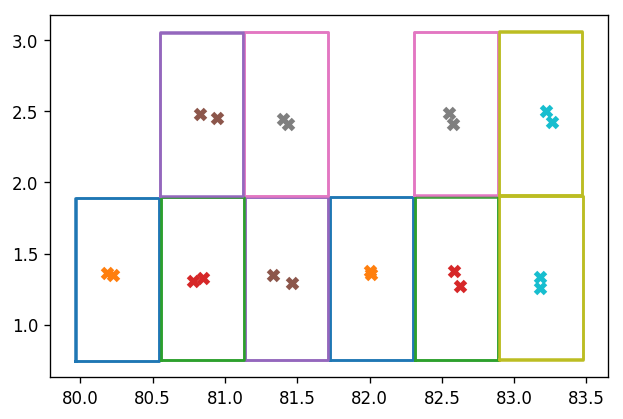

In [33]:
def get_bbox(table):
    ra_field, dec_field = "ALPHAWIN_J2000", "DELTAWIN_J2000"    
    ra = table[ra_field]
    dec = table[dec_field]
    return ([min(ra), min(ra), max(ra), max(ra), min(ra)],
            [min(dec), max(dec), max(dec), min(dec), min(dec)])


filenames = glob.glob("ptf_catalogs/*ctlg")[:20]
bboxes = sc.parallelize(filenames).map(readPTFFile_pandas).map(get_bbox).collect()

for box in bboxes:
    ra_vals, dec_vals = box
    plt.plot(ra_vals, dec_vals, '-')
    plt.plot(np.mean(np.array(ra_vals)[:4])  + 0.05*np.random.randn(),
             np.mean(np.array(dec_vals)[:4]) + 0.05*np.random.randn(), 'x', mew=3)